## Redes neuronales

En esta parte de la práctica nos centraremos en la clasificación de imágenes. Para ello usaremos **redes neuronales convolucionales (CNN)**, ya que tienen altas prestaciones para el reconocimiento y la segmentación de imágenes u objetos contenidos en esta.

#### Dataset: CIFAR-10

Para abordar la clasificación de imágenes usaremos el dataset CIFAR 10, que contiene 60.000  imagenes de 10 clases diferentes: aviones, coches, pájaros, gatos, ciervos, perros, ranas, caballos, barcos, y camiones. Las imágenes son 32x32 píxeles a color. El dataset contiene 6000 imágenes de cada clase.

En primer lugar, cargamos las librerías que vamos a utilizar:

In [2]:
from keras.datasets import cifar10
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import os
from sklearn import preprocessing
import pickle
import pandas as pd
from sklearn import metrics

#### División del dataset en conjuntos de entrenamiento, test y validación


Cargamos el dataset que se encuentra en la librería de keras de Tensorflow. El conjunto de datos viene preparado para que 50.000 de los mismos sean datos de entrenamiento y 10.000 sean datos de test. Adicionalmente, haremos un conjunto de validación con el 20% de los datos de entrenamiento (10.000 datos) teniendo en cuenta las proporciones originales de la variable de salida (clases).

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train,X_valid,y_train,y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=123, stratify = y_train)


Nos aseguramos que los conjuntos de entrenamiento, test y validación tienen las dimensiones esperadas (tamaño de las muestras x 32 píxeles x 32 píxeles x 3 (color)). Además, mostramos una imagen de ejemplo de cada conjunto:

Dimensiones del conjunto de entrenamiento: (40000, 32, 32, 3)
Dimensiones del conjunto de test (10000, 32, 32, 3)
Dimensiones del conjunto de validación (10000, 32, 32, 3) 

40000 muestras de entrenamiento
10000 muestras de test
10000 muestras de validación

Imagen de ejemplo del conjunto de entrenamiento



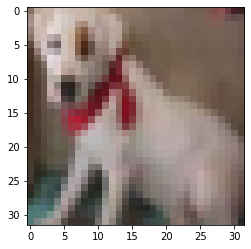

Imagen de ejemplo del conjunto de test



Imagen de ejemplo del conjunto de validación



In [4]:
print("Dimensiones del conjunto de entrenamiento:", X_train.shape)
print("Dimensiones del conjunto de test", X_test.shape)
print("Dimensiones del conjunto de validación", X_test.shape,"\n")


print(X_train.shape[0], "muestras de entrenamiento")
print(X_test.shape[0], "muestras de test")
print(X_valid.shape[0], "muestras de validación\n")


print("Imagen de ejemplo del conjunto de entrenamiento\n")
plt.imshow(X_train[0])
plt.show()
print("Imagen de ejemplo del conjunto de test\n")
plt.imshow(X_test[0])
plt.show()
print("Imagen de ejemplo del conjunto de validación\n")
plt.imshow(X_valid[0])
plt.show()


#### Procesamiento de los datos



Normalizamos el valor de los pixeles para que tengan un valor entre 0 y 1. Para ello dividimos entre 255, pues los valores de RGB de cada pixel van de 0 a 255.

In [5]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
X_valid = X_valid.astype("float32")/255

Mediante el método One Hot Encoding transformamos la variable salida (clase a la que pertenece la imagen) en tantas columnas como clases haya, indicando con un 1 el lugar correspondiente a la clase correspondiente y 0 en todas las demás.

In [6]:
num_classes = 10
y_trainE = keras.utils.to_categorical(y_train, num_classes)
y_testE = keras.utils.to_categorical(y_test, num_classes)
y_validE = keras.utils.to_categorical(y_valid, num_classes)

#### Creación del modelo

* Utilizaremos una red neuronal de 4 capas convolucionales de dos dimensiones. En las dos primeras capas se aplicarán 32 filtros de 3x3 cada uno. En las dos últimas capas se aplicarán 64 filtros de 3x3 cada uno. Este incremento del número de los filtros en cada capa se debe a que cada vez las imágenes son más pequeñas.


* La función de activación de las capas convolucionales será LeakyRelu, una variación de la Relu que presenta cierta mejora respecto a esta **(1)**.


* En cada etapa aplicaremos una capa de  MaxPooling de 2×2 que reduce la imagen que entra a la mitad manteniendo las características “únicas” que detectó cada kernel.



* Finalmente aplanamos nuestros datos con la función flatten() a la salida de la última capa convolucional. Los datos aplanados servirán de entrada a un MLP con una capa oculta compuesta por un total de 500 neuronas y función de activación LeakyRelU y una capa de salida de 10 neuronas con función de activación softmax para que la salida se corresponda con el one hot encoding previamente establecido.


>En un principio, el número de neuronas de la capa oculta del MLP que fijamos era menor (100), sin embargo al aumentar este número hasta 500 observamos una mejoría del modelo en aproximadamente un aumento del 5 % de accuracy en test.


* Para evitar el overfitting (muy común en estos modelos) aplicaremos dos métodos:

 - **Batch Normalization:** Normaliza las características de la capa de entrada escalando las activaciones y mejorando la velocidad de entrenamiento. Reduce el overfitting porque añade ruido a las activaciones de cada capa oculta. Por lo tanto, si usamos batch normalization podemos disminuir el dropout, perdiendo menos información.
 - **Drop Out:** Desactivación aleatoria de un porcentaje de las neuronas de la capa oculta acorde a una probabilidad de descarte previamente definida. De esta forma las neuronas no memorizan parte de la entrada, evitando el sobreajuste. Añadiremos un Drop Out del 20 % tras la primera etapa,aumentando al 40% tras la segunda etapa y finalizando con uno del 50% al final del modelo.
 

* La función de coste que vamos a utilizar para evaluar el modelo es la entropía cruzada categórica, utilizada para tareas de clasificación de múltiples clases como este caso.


* La medida en la que vamos a basar la evaluación del modelo será el accuracy, teniendo en cuenta que el dataset contiene el mismo número de muestras para cada una de las 10 clases. Además, no tenemos ningún interés inicial en clasificar mejor unas clases de imágenes que otras y por tanto una media del acierto de todas ellas es una buena medida para evaluar el modelo.

In [7]:
Nconv1 = 3  # Tamaño del filtro convolucional 1 (píxeles)
Nconv2 = 3  # Tamaño del filtro convolucional 2 (píxeles)
Nfil1 = 32  # Número de filtros de la primera etapa
Nfil2 = 64  # Número de filtros de la segunda etapa
Nneu = 500  # Número de neuronas del MLP final

act_layer = tf.keras.layers.LeakyReLU(alpha=0.4) #Función de activación LeakyReLU

input_shape = (32,32,3)

model = tf.keras.Sequential(
    [
        keras.Input(shape=input_shape),
        # tf.keras.layers.Reshape(input_shape=(Npix*Npix,), target_shape=(Npix, Npix, 1)),
        tf.keras.layers.Conv2D(kernel_size=Nconv1, filters=Nfil1, activation=act_layer, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(kernel_size=Nconv1, filters=Nfil1, activation=act_layer, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.2),
        #-----------------------------------------------
        tf.keras.layers.Conv2D(kernel_size=Nconv2, filters=Nfil2, activation=act_layer, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(kernel_size=Nconv2, filters=Nfil2, activation=act_layer, padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),
        #-----------------------------------------------
        tf.keras.layers.Flatten(),
        #-----------------------------------------------
        tf.keras.layers.Dense(Nneu, activation=act_layer,kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(lr=0.01), metrics=["accuracy"])
model.summary()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
____

>Observando la información anterior podemos ver que la red consta de un valor cercano a 2.100.000 parámetros libres o grados de libertad, que con respecto al número de muestras para entrenamiento (40.000) es bastante más grande. Es por ello que se hace necesario añadir Batch Normalization y Drop Out evitando así el sobreajuste.

#### Entrenamiento del modelo

El siguiente paso es definir el tamaño del mini-batch. Entrenamos el modelo con un tamaño de batch de 80 (número de muestras que se usarán en cada actualización de los parámetros del modelo) y 40 épocas (número de veces que usaremos todos los datos en el proceso de entrenamiento). Elegir un tamaño de batch pequeño ayuda a que haya una menor probabilidad de que se llegue un mínimo local en la función de coste, pero un tamaño de Batch pequeño también puede:

* Aumentar considerablemente el coste computacional ya que se realizan más iteraciones y por lo tanto más evaluaciones de los parámetros por época

* Podemos llegar a tener una mala estima del gradiente

Sin embargo, en nuestro caso hemos visto que es más decisiva la arquitectura de la red que el tamaño del batch utilizado, por eso hemos optado por utilizar valores que previamente se han usado para el mismo propósito y con el mismo dataset:

In [8]:
batch_size = 80
epochs = 40


history = model.fit(X_train, y_trainE, batch_size=batch_size, epochs=epochs,
                    validation_data=(X_test, y_testE),initial_epoch=0)




Train on 40000 samples, validate on 10000 samples
Epoch 1/40
40000/40000 [==============================] - 311s 8ms/sample - loss: 1.7282 - acc: 0.4313 - val_loss: 1.2733 - val_acc: 0.5472
Epoch 2/40
40000/40000 [==============================] - 299s 7ms/sample - loss: 1.1508 - acc: 0.5935 - val_loss: 1.1133 - val_acc: 0.6245
Epoch 3/40
40000/40000 [==============================] - 291s 7ms/sample - loss: 1.0066 - acc: 0.6466 - val_loss: 1.0697 - val_acc: 0.6373
Epoch 4/40
40000/40000 [==============================] - 293s 7ms/sample - loss: 0.9476 - acc: 0.6690 - val_loss: 1.2160 - val_acc: 0.5965
Epoch 5/40
40000/40000 [==============================] - 297s 7ms/sample - loss: 0.9062 - acc: 0.6824 - val_loss: 0.9713 - val_acc: 0.6647
Epoch 6/40
40000/40000 [==============================] - 292s 7ms/sample - loss: 0.8744 - acc: 0.6939 - val_loss: 0.9829 - val_acc: 0.6612
Epoch 7/40
40000/40000 [==============================] - 290s 7ms/sample - loss: 0.8465 - acc: 0.7046 - val_l

### Resultados

Finalmente predecimos sobre los datos de train, test y validación:

In [9]:
otrain=model.predict(X_train)
otest=model.predict(X_test)
ovalid=model.predict(X_valid)

ytrainD=otrain.argmax(axis=1)
ytestD=otest.argmax(axis=1)
yvalidD=ovalid.argmax(axis=1)

pAciertoTrain=accuracy_score(y_train,ytrainD)
pAciertoTest=accuracy_score(y_test,ytestD)
pAciertoValid=accuracy_score(y_valid,yvalidD)

print("Probabilidad de acierto (Train): %s"%(pAciertoTrain))

print("Probabilidad de acierto (Test): %s"%(pAciertoTest))

print("Probabilidad de acierto (Validation): %s"%(pAciertoValid))




Probabilidad de acierto (Train): 0.869125
Probabilidad de acierto (Test): 0.7826
Probabilidad de acierto (Validation): 0.7795


Ahora se procede a cargar los datos de la simulación anterior (con la que mejores resultados hemos obtenido) para obtener determinadas métricas. Los guardamos en el archivo *metrics.dictionary* para que no sea necesario entrenar el modelo siempre que se quiera evaluar:

In [10]:


metrics_dictionary = {'ytrainD':ytrainD,
               'ytestD':ytestD,
               'yvalidD':yvalidD,
               'y_train':y_train,
               'y_test':y_test,
               'y_valid':y_valid}
# Step 1
import pickle
 
# Step 2
with open('metrics.dictionary', 'wb') as metrics_dictionary_file:
 
  # Step 3 
    pickle.dump(metrics_dictionary, metrics_dictionary_file)

In [3]:
with open('metrics.dictionary', 'rb') as metrics_dictionary_file:
    metrics_dictionary = pickle.load(metrics_dictionary_file)

Mostramos las métricas obtenidas al validar el modelo con los datos de validación:

In [4]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
le = preprocessing.LabelEncoder()
le.fit(labels)
y_valid = le.inverse_transform(metrics_dictionary['y_valid'].ravel())
yvalidD = le.inverse_transform(metrics_dictionary['yvalidD'].ravel())

print(metrics.classification_report(y_valid, yvalidD))
confusion_matrix = pd.crosstab(y_valid, yvalidD,
                               rownames=['True'], colnames=['Predicted'],
                               margins=True).T
print('\033[1m' + '\nMatriz de confusión\n' + '\033[0m')
print(confusion_matrix)

              precision    recall  f1-score   support

    airplane       0.76      0.84      0.80      1000
  automobile       0.81      0.95      0.87      1000
        bird       0.76      0.65      0.70      1000
         cat       0.74      0.49      0.59      1000
        deer       0.78      0.72      0.75      1000
         dog       0.63      0.77      0.69      1000
        frog       0.84      0.84      0.84      1000
       horse       0.71      0.90      0.79      1000
        ship       0.89      0.86      0.87      1000
       truck       0.94      0.78      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000


Matriz de confusión

True        airplane  automobile  bird   cat  deer   dog  frog  horse  ship  \
Predicted                                                                     
airplane         839          16    59    32    27     8    1

### Conclusiones - Métricas

* Tal como se ha comentado con anterioridad, al tener el mismo número de muestras por clase la medida del **accuracy** resulta interesante en nuestro estudio con un valor cercano al **80%**.


* La mayoría de las clases presentan un **f1-score alto** salvo las clases gato, pájaro y perro.


* También llama la atención el valor del **49%** de **recall** de la clase **gato** lo cual nos indica que la red neuronal solo detecta la mitad de las imágenes de gatos como gatos y el resto las confunde con el resto de clases (en la mayoría de los casos con perros).


* Un aspecto muy positivo es que el accuracy cuando se valida el modelo con los datos de validación es prácticamente el mismo que con los datos de test (**78%** en ambos casos), por lo que el modelo será muy estable cuando aparezcan imágenes nuevas que todavía no ha visto.

In [5]:
# Utilidades
def show_confusion_matrix(confusion_matrix):
    """
    :param confusion_matrix: numpy ndarray (matrix)
    :return:
    """
    import plotly.figure_factory as ff
    from IPython.display import IFrame

    z = confusion_matrix.T

    x = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    y = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]
    #z_text = [z_text[-1],z_text[1],z_text[0]]
    
    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<i><b>Matriz de confusión</b></i>',
                      #xaxis = dict(title='x'),
                      #yaxis = dict(title='x')
                     )

    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=0.5,
                            y=1.10,
                            showarrow=False,
                            text="Valores reales",
                            xref="paper",
                            yref="paper"))

    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.15,
                            y=0.5,
                            showarrow=False,
                            text="Valores predichos",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))

    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=50, l=200))

    # add colorbar
    fig['data'][0]['showscale'] = True
    #plotly.offline.plot(fig,auto_open=False,filename=filename)
    # IFrame(src=filename, width=900, height=600)
    fig.show()

In [6]:
show_confusion_matrix(metrics.confusion_matrix(metrics_dictionary['y_valid'].ravel(), metrics_dictionary['yvalidD'].ravel()))

### Conclusiones - Matriz de confusión

* La anterior figura nos muestra que los aviones se confunden a veces con pájaros, esto puede deberse a que existan fotografías con aviones y pájaros en la misma posición (los dos volando). 


* También podemos destacar que hay confusión entre gatos, caballos y perros. Nuevamente podemos inferir que podrían existir fotos de perros gatos y caballos en posiciones parecidas.


* Llama la atención que la clase gato, la que menor f1-score posee (59%), se confunda mucho con perros y que la clase camión se confunda con coche y avión. 


* De forma general podemos ver que la red distingue muy bien entre clases que no tienen nada que ver, pero en clases parecidas suele presentar algunos problemas.


* Además, cabe destacar que las imágenes que recibe la red para ser entrenada no tienen una resolución muy alta (32x32) para que el coste computacional sea aceptable para un ordenador estándar. Si no tuvieramos limitación computacional ni temporal y pudieramos entrenarla con imágenes de mayor resolución, seguramente los resultados del modelo mejorarían.


* Una propuesta futura podría ser aumentar el número de filtros o capas de convolución obteniendo más detalles de las imágenes que puedan ayudar a diferenciarse entre estas clases.

### Referencias

**1)** B. Xu, N. Wang, T. Chen, M. Li (2015). Empirical Evaluation of Rectified Activations in Convolutional Network. Recuperado desde: https://arxiv.org/pdf/1505.00853.pdf